# Load libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree

In [2]:
data = pd.read_csv("vars_final_zscale.csv", index_col = 0)

In [3]:
# Look at the data
data.head()

,Fraud,Card_Amount_Act_median_30D,Card_Merch_Amount_max_7D,v_num_card_amount_card14,v_num_card_amount_card7,v_num_merch_amount_card7,v_num_merch_amount_merch14,Card_Merch_Amount_max_30D,Card_State_Amount_max_30D,Card_State_Amount_max_14D,...,Card_Zip_Amount_total_3D,Card_Zip_Amount_max_3D,Card_Zip_Amount_median_3D,Card_Zip_Amount_mean_3D,Card_Amount_median_14D,Card_Merch_Amount_median_7D,Card_State_Amount_mean_30D,Card_State_Amount_mean_14D,v_amount_card_num_card7,Card_Merch_Amount_mean_14D
Recnum,,,,,,,,,,,,,,,,,,,,,
1,0,-0.120119,-0.158959,5.871008,4.898253,0.501112,5.898894,-0.175484,-0.231773,-0.203669,...,-0.127423,-0.156257,-0.188153,-0.188405,-0.245421,-0.188017,-0.194931,-0.196986,-0.472119,-0.187477
2,0,-0.120119,-0.160996,0.518050,0.338047,-0.096451,0.551609,-0.177512,-0.233739,-0.205665,...,-0.128918,-0.158296,-0.190803,-0.191053,-0.248927,-0.190735,-0.197738,-0.199734,-0.411548,-0.190208
3,0,-0.120119,-0.125551,-0.057104,-0.151928,-0.115540,-0.070261,-0.142209,-0.199517,-0.170932,...,-0.102904,-0.122819,-0.144685,-0.144963,-0.187902,-0.143425,-0.148884,-0.151906,-0.091059,-0.142679
4,0,-0.120119,-0.162273,5.697684,4.750597,0.827875,5.898894,-0.178785,-0.234972,-0.206917,...,-0.129855,-0.159574,-0.192465,-0.192714,-0.251127,-0.192440,-0.199498,-0.201458,-0.471886,-0.191920
5,0,-0.120119,-0.158959,5.871008,4.898253,0.501112,5.898894,-0.175484,-0.231773,-0.203669,...,-0.127423,-0.156257,-0.188153,-0.188405,-0.245421,-0.188017,-0.194931,-0.196986,-0.472119,-0.187477


In [4]:
# split data into out of date(after 11/1/10), train and test
oot_df = data.iloc[84300:,:]
trte_df = data.iloc[:84299,:]

In [20]:
def multipltrun(a=5,v=6,md=5,lr=0.1,ne=1000):
    '''
    This function run model on different samples based on user input:
    "a" (int) how many randome samples, default as 5
    "v" (int) how many variables, default as 6 (most important ones from backward selection)
    users can modify model based on different machine learning algorithm and its parameters
    
    FDR is calculated by first sorting outcome in descending order and cut off at 3%,
    sum number of fraud records on top 3% and divided by total fraud racords for that sample
    
    Final output would be a dataframe contains FDR at 3% for training set, testing set, and oot. 
    '''
    #declare dict
    FDRdict={"train":[],"test":[],"oot":[]}
    
    for i in range(a):        
        #split training and testing
        train, test = train_test_split(trte_df, test_size=0.2,random_state=i)
        
        # split lables and features and t
        train_lab = train["Fraud"]
        train_fea = train.iloc[:,1:v+1]

        test_lab = test["Fraud"]
        test_fea = test.iloc[:,1:v+1]

        oot_lab=oot_df["Fraud"]
        oot_fea=oot_df.iloc[:,1:v+1]

        #define model
        model=XGBClassifier(max_depth=md, 
                    learning_rate=lr, 
                    n_estimators=ne, 
                    subsample=0.8, 
                    gamma=1)   #modify based on your model
        
        #fit model
        model.fit(train_fea,train_lab) #modify based on your model
    
        #calculate FDR
        for sets in ["train","test","oot"]:
            fea=vars()[sets+'_fea'] 
            lab=vars()[sets+'_lab']
            prob=pd.DataFrame(model.predict_proba(fea)) #modify based on your model
            result=pd.concat([pd.DataFrame(lab).reset_index(),prob],axis=1)
            topRows=int(round(len(result)*0.03))
            top3per=result.sort_values(by=1,ascending=False).head(topRows)
            FDR=sum(top3per.loc[:,'Fraud'])/sum(result.loc[:,'Fraud'])
            FDRdict[sets].append(FDR)
    
    #convert into dataframe
    FDR_df=pd.DataFrame(FDRdict)
   
    #add new row to calculate mean
    FDR_df.loc['mean']=FDR_df.mean()
    
    return FDR_df

# Number of variables
try different number of variables [6,10,15,20]

In [6]:
multipltrun()

,train,test,oot
0,1.0,0.835616,0.279330
1,1.0,0.827778,0.284916
2,1.0,0.804233,0.284916
3,1.0,0.789157,0.279330
4,1.0,0.876543,0.273743
mean,1.0,0.826665,0.280447


In [7]:
multipltrun(v=10)

,train,test,oot
0,1.0,0.938356,0.329609
1,1.0,0.955556,0.351955
2,1.0,0.915344,0.312849
3,1.0,0.933735,0.340782
4,1.0,0.950617,0.340782
mean,1.0,0.938722,0.335196


In [8]:
multipltrun(v=15) #15 perform the best and have the least amount of variables

,train,test,oot
0,1.0,0.938356,0.413408
1,1.0,0.933333,0.491620
2,1.0,0.904762,0.452514
3,1.0,0.933735,0.424581
4,1.0,0.944444,0.418994
mean,1.0,0.930926,0.440223


In [9]:
multipltrun(v=20)

,train,test,oot
0,1.0,0.938356,0.480447
1,1.0,0.944444,0.430168
2,1.0,0.894180,0.474860
3,1.0,0.927711,0.441341
4,1.0,0.944444,0.424581
mean,1.0,0.929827,0.450279


# Parameters
Try different paramters

### max_depth [3,5,10]

In [13]:
multipltrun(md=3,v=6)

,train,test,oot
0,0.987738,0.828767,0.290503
1,0.982857,0.827778,0.284916
2,0.988423,0.788360,0.307263
3,0.994398,0.795181,0.290503
4,0.991643,0.839506,0.296089
mean,0.989012,0.815918,0.293855


In [21]:
multipltrun(md=3,v=10)

,train,test,oot
0,1.0,0.938356,0.335196
1,1.0,0.944444,0.374302
2,1.0,0.904762,0.312849
3,1.0,0.933735,0.357542
4,1.0,0.950617,0.340782
mean,1.0,0.934383,0.344134


In [22]:
multipltrun(md=3,v=15) #good enough

,train,test,oot
0,1.0,0.938356,0.513966
1,1.0,0.938889,0.497207
2,1.0,0.899471,0.502793
3,1.0,0.927711,0.430168
4,1.0,0.938272,0.469274
mean,1.0,0.928540,0.482682


In [23]:
multipltrun(md=5,v=10)

,train,test,oot
0,1.0,0.945205,0.374302
1,1.0,0.944444,0.368715
2,1.0,0.915344,0.346369
3,1.0,0.927711,0.357542
4,1.0,0.944444,0.335196
mean,1.0,0.935430,0.356425


In [24]:
multipltrun(md=5,v=15)

,train,test,oot
0,1.0,0.945205,0.430168
1,1.0,0.944444,0.446927
2,1.0,0.904762,0.480447
3,1.0,0.933735,0.441341
4,1.0,0.932099,0.435754
mean,1.0,0.932049,0.446927


In [14]:
multipltrun(md=10,v=6)

,train,test,oot
0,1.0,0.821918,0.279330
1,1.0,0.822222,0.284916
2,1.0,0.820106,0.284916
3,1.0,0.807229,0.279330
4,1.0,0.870370,0.279330
mean,1.0,0.828369,0.281564


In [25]:
multipltrun(md=10,v=10)

,train,test,oot
0,1.0,0.938356,0.391061
1,1.0,0.938889,0.402235
2,1.0,0.915344,0.407821
3,1.0,0.927711,0.385475
4,1.0,0.938272,0.363128
mean,1.0,0.931714,0.389944


In [26]:
multipltrun(md=10,v=15)

,train,test,oot
0,1.0,0.938356,0.497207
1,1.0,0.955556,0.530726
2,1.0,0.899471,0.502793
3,1.0,0.915663,0.441341
4,1.0,0.938272,0.497207
mean,1.0,0.929463,0.493855


## learning_rate [0.01,0.05,0.1]

In [28]:
multipltrun(md=3,v=15,lr=0.01)

,train,test,oot
0,0.877384,0.828767,0.379888
1,0.878571,0.805556,0.418994
2,0.876990,0.777778,0.441341
3,0.879552,0.837349,0.402235
4,0.878830,0.839506,0.452514
mean,0.878265,0.817791,0.418994


In [29]:
multipltrun(md=3,v=15,lr=0.05) #result similar to md=3,v=15,lr=0.1

,train,test,oot
0,0.990463,0.924658,0.508380
1,0.991429,0.938889,0.525140
2,0.995658,0.888889,0.541899
3,0.992997,0.903614,0.458101
4,0.991643,0.919753,0.474860
mean,0.992438,0.915161,0.501676


### n_estimator [100,500,1000]

In [30]:
multipltrun(md=3,v=15,lr=0.05,ne=100)

,train,test,oot
0,0.792916,0.732877,0.368715
1,0.791429,0.744444,0.363128
2,0.803184,0.735450,0.374302
3,0.782913,0.765060,0.346369
4,0.793872,0.783951,0.357542
mean,0.792863,0.752356,0.362011


In [31]:
multipltrun(md=3,v=15,lr=0.05,ne=500)

,train,test,oot
0,0.955041,0.876712,0.486034
1,0.945714,0.888889,0.452514
2,0.965268,0.846561,0.486034
3,0.960784,0.873494,0.441341
4,0.955432,0.895062,0.486034
mean,0.956448,0.876144,0.470391


In [32]:
multipltrun(md=3,v=15,lr=0.1,ne=100)

,train,test,oot
0,0.871935,0.821918,0.402235
1,0.872857,0.811111,0.363128
2,0.878437,0.767196,0.424581
3,0.869748,0.831325,0.391061
4,0.876045,0.858025,0.480447
mean,0.873804,0.817915,0.412291


In [33]:
multipltrun(md=3,v=15,lr=0.1,ne=500)

,train,test,oot
0,0.987738,0.938356,0.480447
1,0.991429,0.927778,0.530726
2,0.992764,0.899471,0.519553
3,0.991597,0.915663,0.435754
4,0.988858,0.907407,0.491620
mean,0.990477,0.917735,0.491620


# Plot

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [60]:
#split training and testing
train, test = train_test_split(trte_df, test_size=0.2,random_state=0)
        
# split lables and features 
train_lab = train["Fraud"]
train_fea = train.iloc[:,1:16]

test_lab = test["Fraud"]
test_fea = test.iloc[:,1:16]

oot_lab=oot_df["Fraud"]
oot_fea=oot_df.iloc[:,1:16]

#define model
model=XGBClassifier(max_depth=3, 
            learning_rate=0.1, 
            n_estimators=500, 
            subsample=0.8, 
            colsample_bytree=1, 
            gamma=1)   #modify based on your model

#fit model
model.fit(train_fea,train_lab) #modify based on your model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

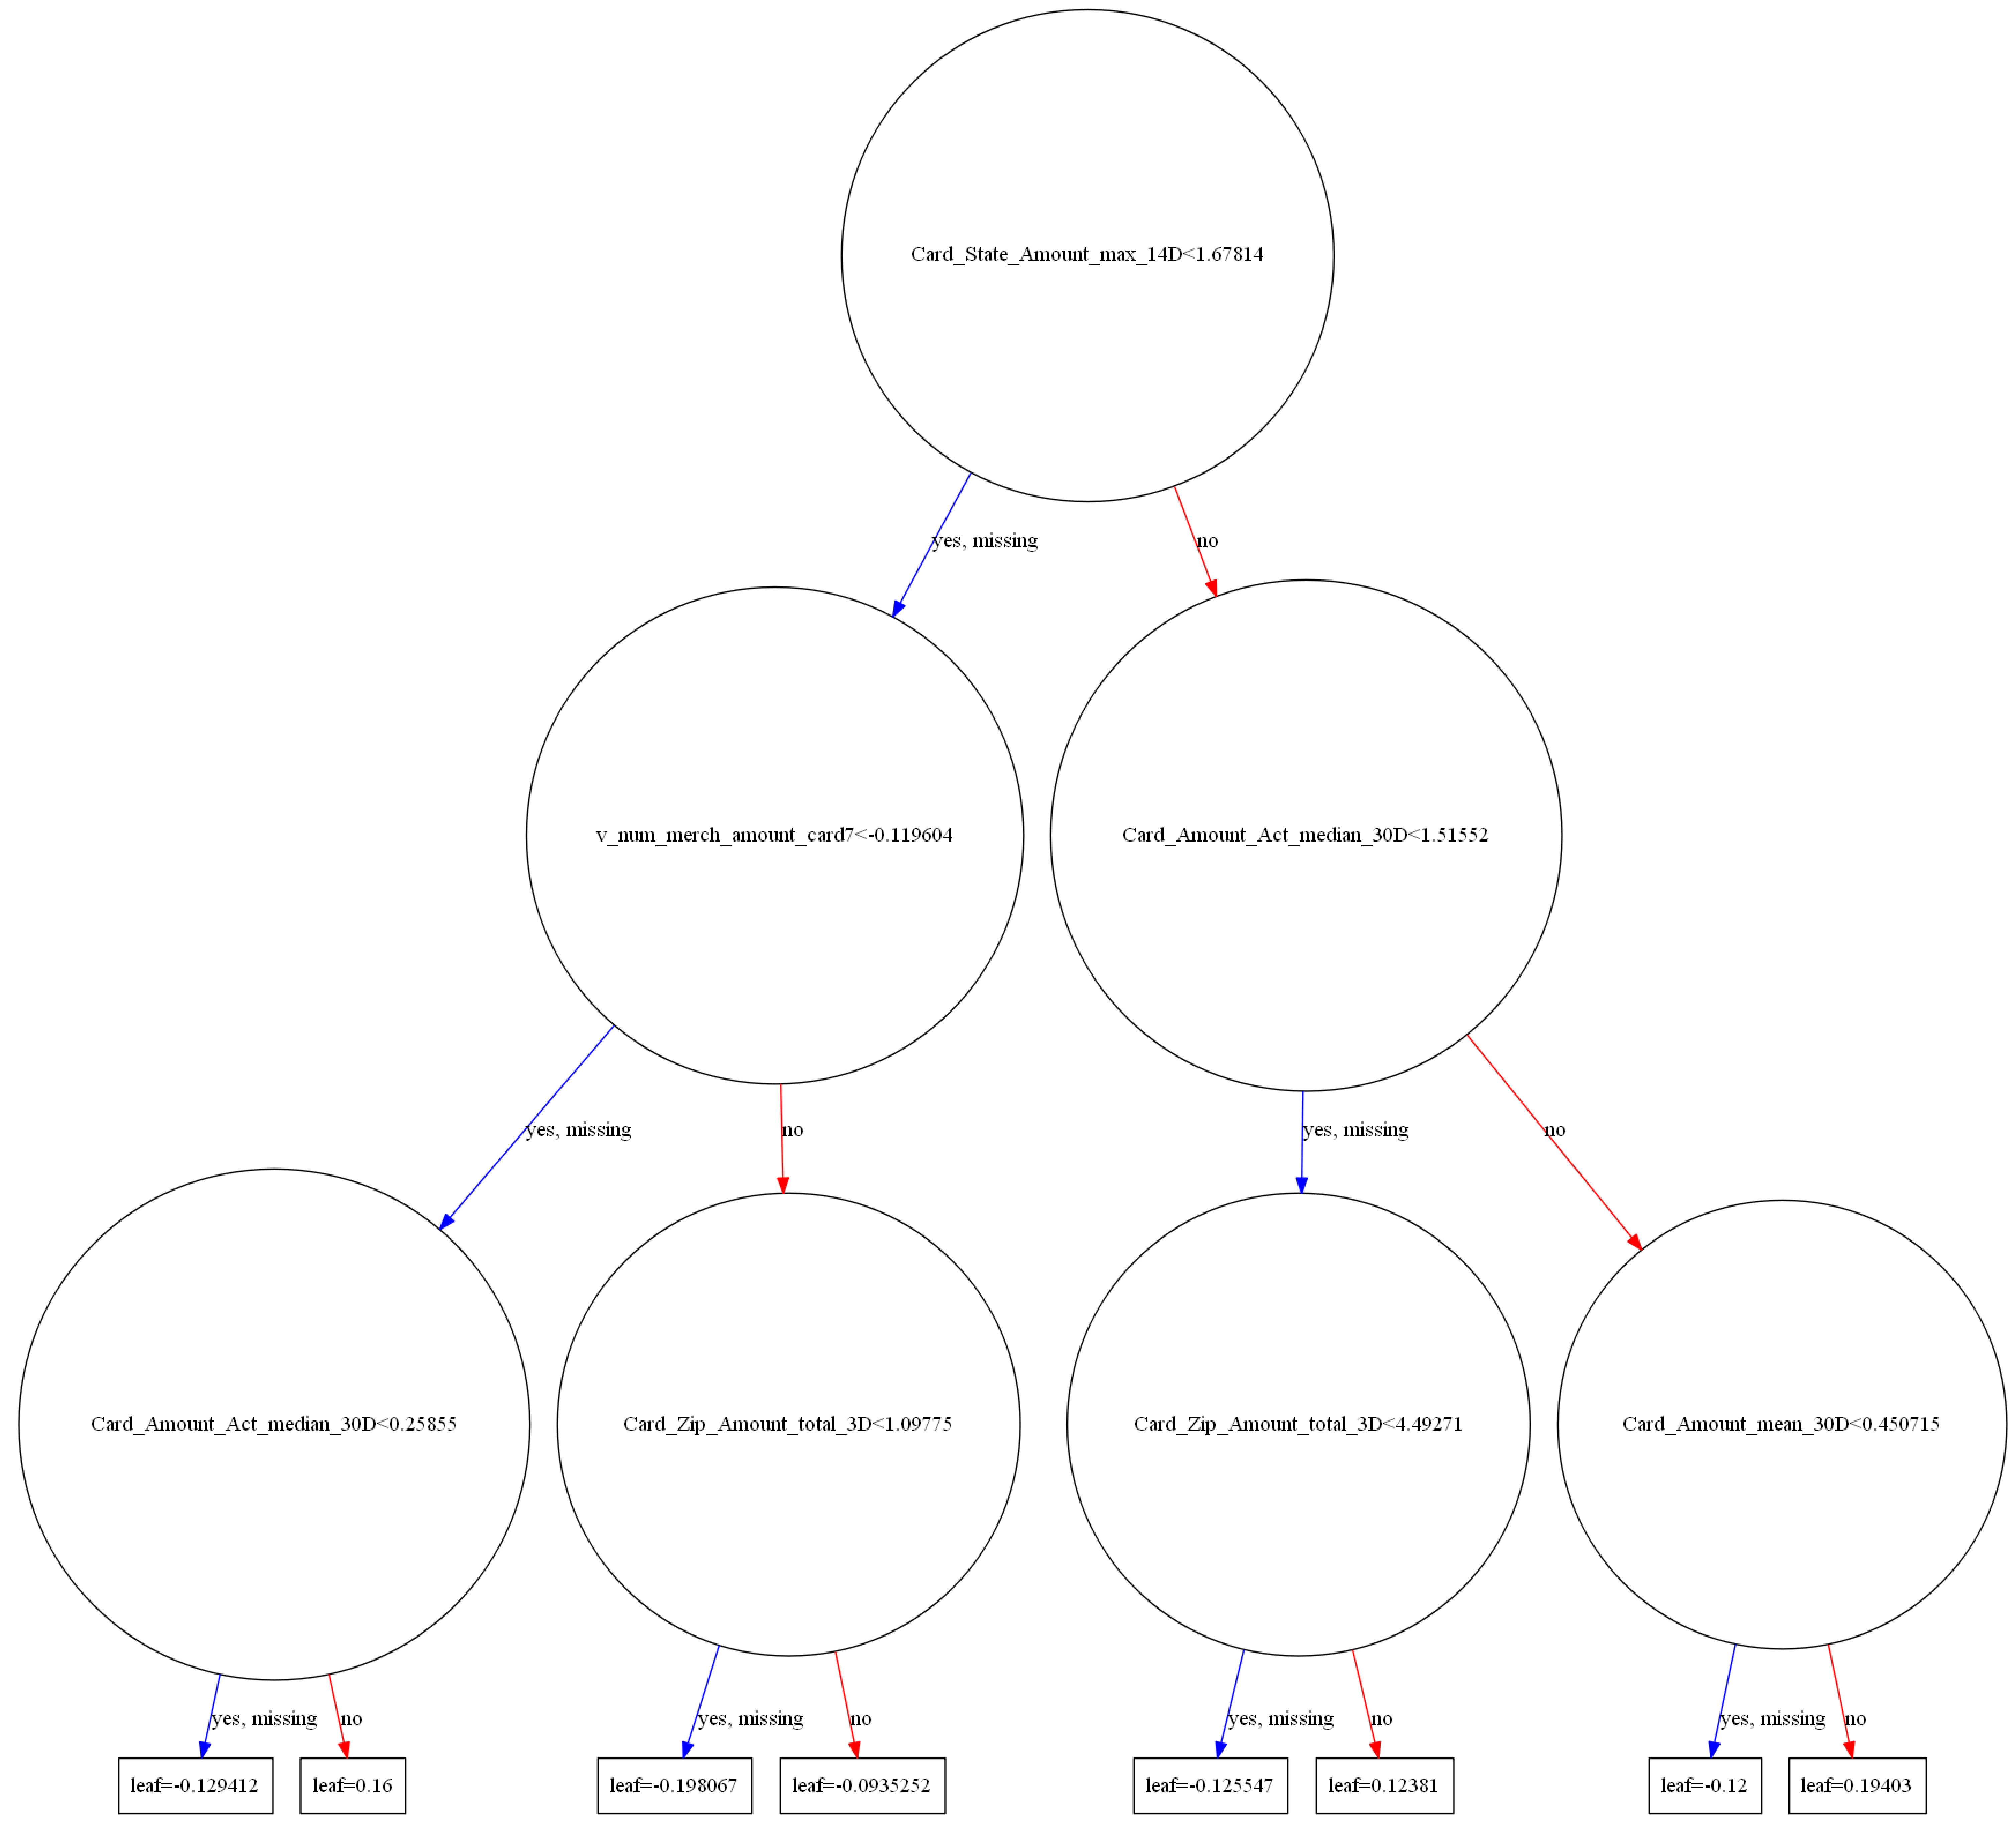

In [61]:
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [46]:
##########

In [54]:
#split training and testing
train, test = train_test_split(trte_df, test_size=0.2,random_state=0)
        
# split lables and features 
train_lab = train["Fraud"]
train_fea = train.loc[:,lst]

test_lab = test["Fraud"]
test_fea = test.loc[:,lst]

oot_lab=oot_df["Fraud"]
oot_fea=oot_df.loc[:,lst]

#define model
model=XGBClassifier(max_depth=3, 
            learning_rate=0.1, 
            n_estimators=500, 
            subsample=0.8, 
            colsample_bytree=1, 
            gamma=1)   #modify based on your model

#fit model
model.fit(train_fea,train_lab) #modify based on your model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [50]:
lst=['Card_State_Amount_max_14D',
    'v_num_merch_amount_card7',
    'Card_Amount_Act_mean_30D',
    'Card_Amount_Act_median_30D',
    'Card_Zip_Amount_total_3D']

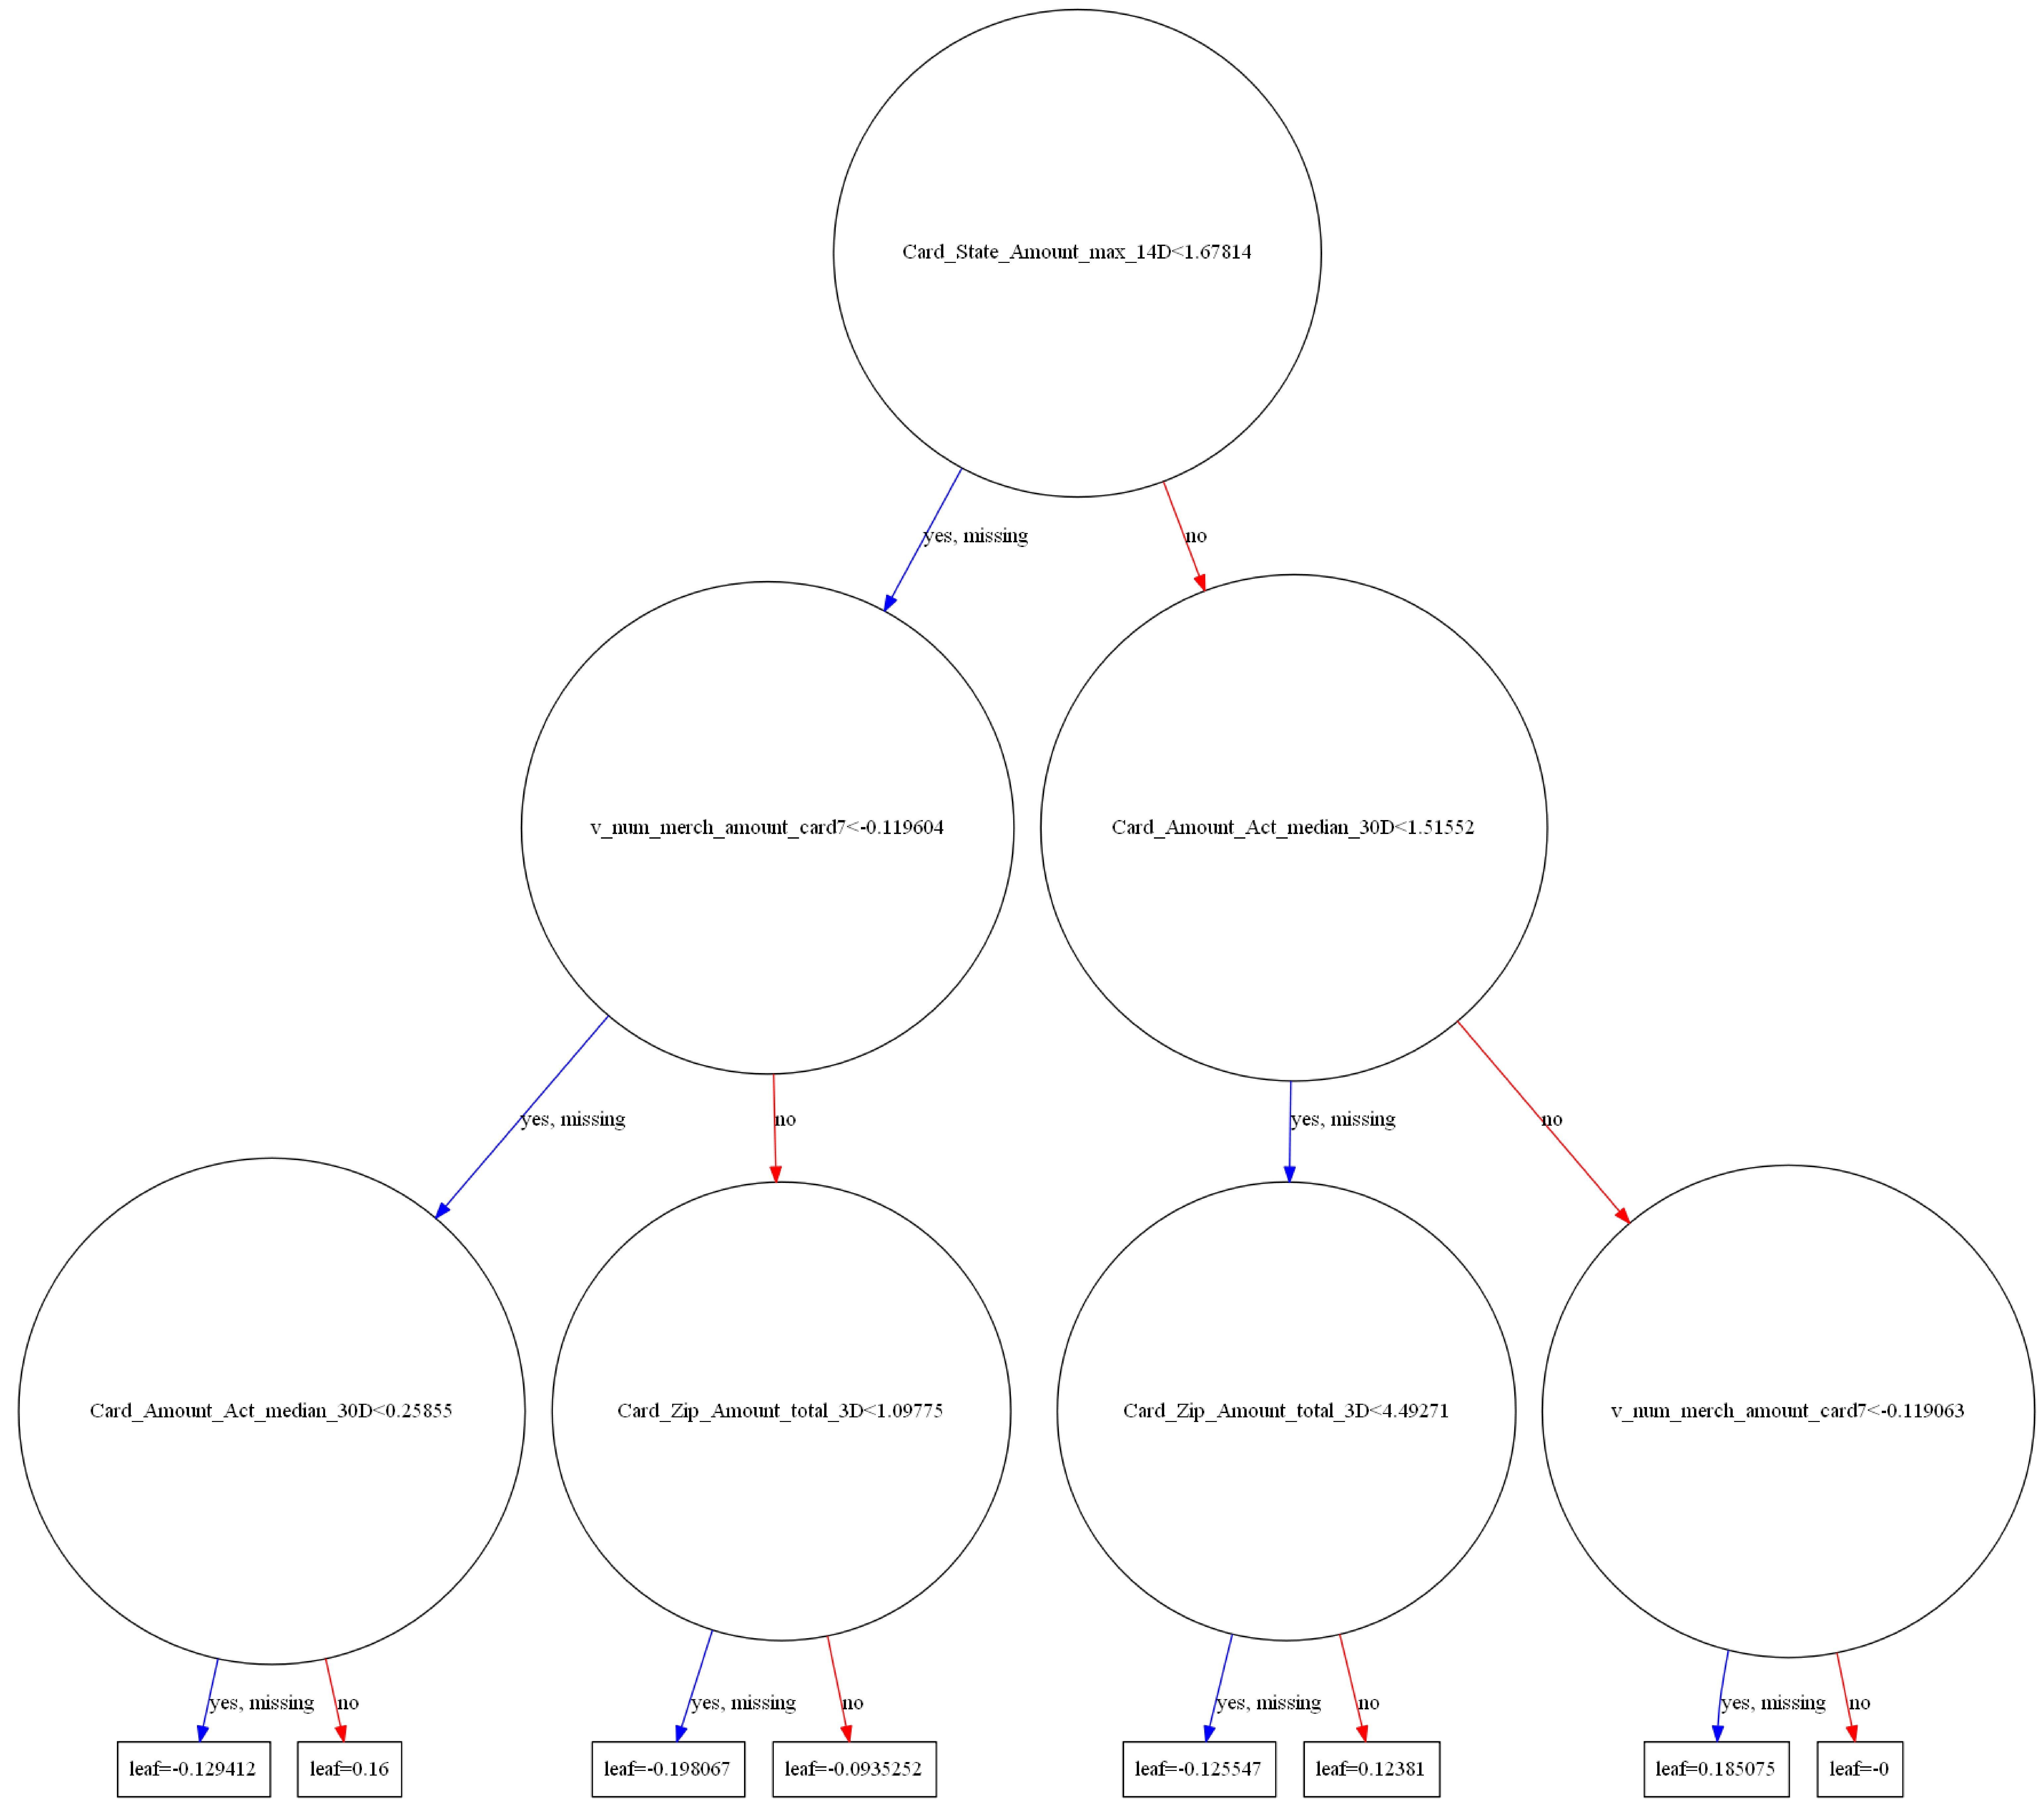

In [55]:
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [57]:
def lstrun(lst,a=5,v=6,md=5,lr=0.1,ne=1000):
    '''
    This function run model on different samples based on user input:
    "a" (int) how many randome samples, default as 5
    "v" (int) how many variables, default as 6 (most important ones from backward selection)
    users can modify model based on different machine learning algorithm and its parameters
    
    FDR is calculated by first sorting outcome in descending order and cut off at 3%,
    sum number of fraud records on top 3% and divided by total fraud racords for that sample
    
    Final output would be a dataframe contains FDR at 3% for training set, testing set, and oot. 
    '''
    #declare dict
    FDRdict={"train":[],"test":[],"oot":[]}
    
    for i in range(a):        
        #split training and testing
        train, test = train_test_split(trte_df, test_size=0.2,random_state=i)
        
       # split lables and features 
        train_lab = train["Fraud"]
        train_fea = train.loc[:,lst]

        test_lab = test["Fraud"]
        test_fea = test.loc[:,lst]

        oot_lab=oot_df["Fraud"]
        oot_fea=oot_df.loc[:,lst]

        #define model
        model=XGBClassifier(max_depth=3, 
                    learning_rate=0.1, 
                    n_estimators=500, 
                    subsample=0.8, 
                    colsample_bytree=1, 
                    gamma=1)   #modify based on your model

        
        #fit model
        model.fit(train_fea,train_lab) #modify based on your model
    
        #calculate FDR
        for sets in ["train","test","oot"]:
            fea=vars()[sets+'_fea'] 
            lab=vars()[sets+'_lab']
            prob=pd.DataFrame(model.predict_proba(fea)) #modify based on your model
            result=pd.concat([pd.DataFrame(lab).reset_index(),prob],axis=1)
            topRows=int(round(len(result)*0.03))
            top3per=result.sort_values(by=1,ascending=False).head(topRows)
            FDR=sum(top3per.loc[:,'Fraud'])/sum(result.loc[:,'Fraud'])
            FDRdict[sets].append(FDR)
    
    #convert into dataframe
    FDR_df=pd.DataFrame(FDRdict)
   
    #add new row to calculate mean
    FDR_df.loc['mean']=FDR_df.mean()
    
    return FDR_df

In [59]:
lstrun(lst,md=3,lr=0.1,ne=500)

,train,test,oot
0,0.945504,0.849315,0.351955
1,0.937143,0.811111,0.357542
2,0.940666,0.777778,0.368715
3,0.942577,0.825301,0.351955
4,0.937326,0.864198,0.379888
mean,0.940643,0.825541,0.362011
